# Lab 5: A Black-Box Adversarial Attack (3/3)
In this lab, we'll carry out an adversarial attack in the **black box** case: we don't have the weights of the network we're trying to trick (the **target model**), and instead we can only give it inputs and see its outputs.

Black-box adversarial attacks are based on the fact that adversarial examples are _transferable_: if it tricks one network, it will likely trick another (but less well).
So, since we need network weights to make adversarial examples, we train a second model, the **surrogate model**, to act like the target model.
To do this, we'll use the target model as an "oracle" to make a dataset where the features are from real examples, and the labels are the outputs of the target model on those examples.
If the surrogate model learns to output the same probabilities as the target model on a given input, its internal representations are likely similar.
Then, when we make an adversarial example for the surrogate model, it should also trick the target model.

The end result of this lab should be an image which looks close to some image in the dataset, but tricks the target network into assigning high confidence to some other class. 

# Link : https://colab.research.google.com/drive/1Q9A83J4NeXrPjdknJyYScverxizH-P_v#scrollTo=vV9Cunbcro9m

## Section 0: Load the data
This uses the same dataset as last time, so just copy the data over here in the same format.
The same data loading and preprocessing as before is in place.

In [225]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# I used this to upload the data files onto the google colab platform
# I also had to manually create a data folder

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving X.npy to X.npy
Saving Y.npy to Y.npy


In [226]:
# Seed numpy rng for reproducibility
np.random.seed(1337)

# Load data
x_all = np.load('data/X.npy')
y_all = np.load('data/Y.npy')

# Maps dataset-provided label to true label
label_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

# Correct dataset labels
for row in range(y_all.shape[0]):
    dataset_label = np.where(y_all[row])[0][0]
    y_all[row, :] = np.zeros(10)
    y_all[row, label_map[dataset_label]] = 1
    
# Shuffle features and targets together
# Credit for this technique to:
# https://stackoverflow.com/questions/4601373/
# better-way-to-shuffle-two-numpy-arrays-in-unison
rng_state = np.random.get_state()
np.random.shuffle(x_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

# Add a dummy channel axis to input images
x_all = np.expand_dims(x_all, axis=-1)

# Center and rescale data to the range [-1, 1]
x_all = x_all - 0.5
x_all = x_all * 2

# Create a validation set from 30% of the available data
n_points = x_all.shape[0]
n_test = int(n_points * 0.3)
n_train = n_points - n_test
x_train, x_test = np.split(x_all, [n_train], axis=0)
y_train, y_test = np.split(y_all, [n_train], axis=0)

## Section 1: Train the black-box model
Below, I've written a CNN in Keras to classify images from the dataset, and the code to train it.
This will act as the "black box model."

Train the model using the code below.
It should hit about 95-96% validation accuracy on the dataset.

In [227]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D

inputs = Input(shape=(64, 64, 1))
layer = Conv2D(16, 5, strides=(2, 2), activation='relu')(inputs)
layer = Conv2D(16, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(32, 3, activation='relu')(layer)
layer = Conv2D(32, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
probs = Dense(10, activation='softmax')(layer)

target_model = Model(inputs, probs)
target_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 16)        416       
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 conv2d_33 (Conv2D)          (None, 10, 10, 32)        9248      
                                                           

In [228]:
from tensorflow.keras.optimizers import Adam

opt = Adam(1e-3)
target_model.compile(opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [229]:
target_model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=15)

Epoch 1/15
46/46 [==============================] - 4s 79ms/step - loss: 2.0934 - accuracy: 0.2195 - val_loss: 1.2899 - val_accuracy: 0.6019
Epoch 2/15
46/46 [==============================] - 3s 73ms/step - loss: 0.9557 - accuracy: 0.6877 - val_loss: 0.8937 - val_accuracy: 0.6926
Epoch 3/15
46/46 [==============================] - 3s 71ms/step - loss: 0.6500 - accuracy: 0.7860 - val_loss: 0.6480 - val_accuracy: 0.7848
Epoch 4/15
46/46 [==============================] - 3s 72ms/step - loss: 0.4477 - accuracy: 0.8601 - val_loss: 0.3749 - val_accuracy: 0.8932
Epoch 5/15
46/46 [==============================] - 3s 72ms/step - loss: 0.2933 - accuracy: 0.9037 - val_loss: 0.3553 - val_accuracy: 0.8948
Epoch 6/15
46/46 [==============================] - 3s 71ms/step - loss: 0.2052 - accuracy: 0.9328 - val_loss: 0.3449 - val_accuracy: 0.9078
Epoch 7/15
46/46 [==============================] - 3s 72ms/step - loss: 0.1365 - accuracy: 0.9564 - val_loss: 0.4534 - val_accuracy: 0.8867
Epoch 8/15
46

## Section 2: Build an "oracle dataset" and data pipeline (3/3)
Now, we'll treat the target model as a black box: pretend we don't have access to its weights or its original input data.
In the wild, all we can do is give it inputs and see its outputs.

We want to train a surrogate model to act similarly to the target model, so create a fake "oracle dataset" where the features are `x_all` and the outputs are the 10-vectors of probability the target model predicts for that input.

Then, set up any `tf.data.Dataset` objects you need.
In this case we don't have a test set, just a training set. Add `tf.summary.SummaryWriter`s to save logs to `./logs/surrogate` and `./logs/adversarial`.

In [230]:
# NOTE 3/3

n_epochs = 5
batch_size = 32

n_batches_per_epoch = len(y_all) // batch_size
dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))\
    .shuffle(x_all.shape[0]).batch(batch_size).cache().repeat(n_epochs)

surrogate_writer = tf.summary.create_file_writer('./logs/surrogate')
adversarial_writer = tf.summary.create_file_writer('./logs/adversarial')

## Section 3: Build a surrogate model (3/3)
The surrogate model is designed to act similarly to the target model, so that adversarial examples we create for it will also work on the target model.
Feel free to use any architecture you want, but matching the target architecture closely (maybe with a bit more capacity) is a good bet.

Copy code from last week's assignment liberally.
Most likely, you won't have to write all that much new code in this section.

This should involve tensors that:
 - Act as hidden convolutional and dense layers
 - Compute the logits and probabilities for a batch of input images
 - Compute the predicted digit from the probabilities
 - Compute the mean cross-entropy loss over a batch

### 3.1 Dense and convolutional layers
Copy the `Dense` and `Conv` classes you wrote last week here. You will need them to construct the graph of your surrogate model.

In [231]:
class Dense(tf.Module):
    '''
    Creates a dense layer module.
    
    Parameters
    ----------
    dim_input: int
        Number of features in the input representation.
    dim_output: int
        Number of features in the output representation.
        Equivalently, number of units in this layer.
    do_activation: bool
        Whether or not to apply ReLU activation.
    postfix: string
        Postfix on name scopes in this layer.
        Used to simplify visualizations.
    name: string
        Name of layer.
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    def __init__(self, dim_input, dim_output, do_activation=True, postfix='', name=None):
        super().__init__(name=name)
        with tf.name_scope('dense' + postfix):
            self.do_activation = do_activation
            self.weights = tf.Variable(tf.initializers.he_uniform()(shape=(dim_input,dim_output), dtype=tf.float32), \
                                   name='weights'+postfix)
            self.bias = tf.Variable(tf.zeros_initializer()(shape=(dim_output), dtype=tf.float32), name='bias'+postfix)
      
        
    def __call__(self, x):
        if self.do_activation:
            return tf.nn.relu(tf.math.add(tf.matmul(x, self.weights), self.bias))
        else:
            return tf.math.add(tf.matmul(x, self.weights), self.bias)

In [232]:
class Conv(tf.Module):
    '''
    Creates a convolutional layer module.
    
    Parameters
    ----------
    input_channels: int
        Number of channels in the input representation.
    n_filters: int
        Number of channels in the output representation.
        Equivalently, number of filters in this layer.
    filter_size: int
        Width and height of each kernel in the layer's filters.
    stride: int
        Stride to use in the x and y directions for the
        convolution operation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    pool_size: int
        If > 1, does max pooling of this size to the
        width and height axes of the activation.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
    name: string
        Name of layer
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    def __init__(self, input_channels, n_filters, 
                 filter_size=3, stride=1,
                 do_activation=True, pool_size=1,
                 postfix='', name=None):
        super().__init__(name=name)
        with tf.name_scope('conv' + postfix):
            self.do_activation = do_activation
            self.pool_size = pool_size
            self.stride = stride
            self.filters = tf.Variable(tf.initializers.he_uniform()\
                                       (shape= (filter_size,filter_size,input_channels,n_filters), \
                                        dtype=tf.float32), name='filters'+postfix)
            self.bias = tf.Variable(tf.zeros_initializer()\
                                       (shape= (n_filters), \
                                        dtype=tf.float32), name='bias'+postfix)
            
            
    def image(self, x):
      conv = tf.nn.conv2d(x, self.filters, strides = [1, self.stride, self.stride, 1], padding='SAME')
      relu = tf.nn.bias_add(conv, self.bias)
      if self.do_activation:
          relu = tf.nn.relu(relu)
      return relu
            
    def __call__(self, x):
        toReturn = self.image(x)
        if self.pool_size > 1:
            toReturn = tf.nn.max_pool(toReturn, ksize = [1, self.pool_size, self.pool_size, 1], strides=[1, self.pool_size, self.pool_size, 1], padding='VALID')
        return toReturn

### 3.2: The rest of the model
Write a `tf.Module` class called `Surrogate` that uses your classes from last week to be your surrogate model.

#### 3.2.1: Adversarial noise
This is the only part of the model that really differs from last week, and it's a bit tricky.

Add a variable to the graph that represents the adversarial noise we'll add to one example.
It should be the shape of a single input image and initialized to zeros.
In addition, pass (to the `Variable()` constructor) the keyword argument `constraint=lambda x: tf.clip_by_value(x, -0.3, 0.3)`.
Every time the variable is updated, it will become the result of the lambda function, which in this case constrains its pixel values to be in the range -0.3 to 0.3.
(Equivalently, at every step we re-project the adversarial noise back into a hypercube at the origin with side length 0.6).
I found that 0.3 works well, but feel free to change this value -- smaller values will produce less obvious noise, while larger values will produce more successful attacks. 

Add a boolean `tf.Variable` (default False) named "use_noise" to the graph.
This will act as a "switch" controlling whether a given run uses adversarial noise. Additionally, add the argument `trainable=False` to the constructor, as it makes no sense to update this variable during training.

Add a `tf.cond()` operation that, depending on `use_noise`, switches between the input image and the image plus the adversarial noise.
This allows us to train the surrogate model without adversarial noise, then enable it when crafting the adversarial example.

In [233]:
# NOTE 3/3

class Surrogate(tf.Module):
    def __init__(self, name=None):
        self.adv_noise = tf.Variable(tf.zeros_initializer()(shape= (1,64,64,1), \
              dtype=tf.float32),constraint=lambda x: tf.clip_by_value(x, -0.3, 0.3))
        self.use_noise = tf.Variable(False, trainable=False)
        self.conv_layer1 = Conv(1, 16, filter_size=5, stride=2, do_activation=True, pool_size=1, postfix='Conv Layer 1')
        self.conv_layer2 = Conv(16, 16, filter_size=3, stride=1, do_activation=True, pool_size=2, postfix='Conv Layer 2')
        self.conv_layer3 = Conv(16, 32, filter_size=3, stride=1, do_activation=True, pool_size=1, postfix='Conv Layer 3')
        self.conv_layer4 = Conv(32, 32, filter_size=3, stride=1, do_activation=True, pool_size=2, postfix='Conv Layer 4')
        self.conv_layer5 = Conv(32, 64, filter_size=3, stride=1, do_activation=True, pool_size=1, postfix='Conv Layer 5')
        self.conv_layer6 = Conv(64, 64, filter_size=3, stride=1, do_activation=True, pool_size=2, postfix='Conv Layer 6')
        self.dense_layer7 = Dense(16*64, 128, do_activation=True, postfix='Dense Layer 7') 
        self.dense_layer8 = Dense(128, 10, do_activation=False, postfix='Dense Layer 8')
        
    def logits(self, x):
        conv_all = self.conv_layer6(self.conv_layer5(self.conv_layer4(self.conv_layer3(self.conv_layer2(self.conv_layer1(x))))))
        conv_all = tf.reshape(conv_all, shape = [-1, 16*64])
        dense_all = self.dense_layer8(self.dense_layer7(conv_all))
        return dense_all
    
    def find_x(self, x):
      return tf.cond(self.use_noise, lambda: x + self.adv_noise, lambda: x)

    @tf.function
    def __call__(self, x):
        add = self.find_x(x)
        logits = self.logits(add)
        return tf.nn.softmax(logits)



### 3.3: Compute cross-entropy loss
Write a `_loss` function to compute the cross-entropy loss.

In [234]:
# NOTE 3/3

def _loss(target, actual):
    mse_per_example = tf.nn.softmax_cross_entropy_with_logits(target, actual)
    mse_batch = tf.reduce_mean(mse_per_example)  
    return mse_batch

### 3.4: Surrogate and adversarial loss and gradients
Add an optimizer and train method we'll use to train the surrogate model to act like the target model.
It should just minimize the cross-entropy loss between the model's predictions and the targets. When `use_noise` is false, we will not have any gradients to update the adversarial noise tensor with because it will not be referenced in our computation. This will cause TensorFlow to throw (very annoying) warning messages about nonexistent gradients. To suppress this, we can use this neat trick (credit [here](https://stackoverflow.com/questions/60022462/how-to-suppress-specific-warning-in-tensorflow-python)) to preprocess our gradients,
```
gradients = g.gradient(loss, model.trainable_variables)
surrogate_optimizer.apply_gradients( 
                            (grad, var) for (grad, var) in zip(gradients, model.trainable_variables)
                             if grad is not None)
```

When training the surrogate model, we want to change the model parameters to minimize the loss.
When creating the adversarial example, we want to do something very different: _change the adversarial noise tensor alone to maximize the loss_.

So, add an `adversarial=False` argument to your train method so we can toggle whether or not to train the surrogate model, or the adversarial noise.

Define a new adversarial loss which is the negative of the original loss, and a new optimizer to minimize it.
When you call `minimize()`, pass in the keyword argument `var_list=[model.noise]`, where "noise" is the name of your adversarial noise tensor.
This will prevent the optimizer from changing the weights of the model when we optimize the adversarial noise.

Add a summary scalar to plot the adversarial loss decreasing. Then, add a summary histogram and a summary image for the adversarial noise tensor, so we can plot it as we're learning the adversarial example.
Finally, add a summary image for the output of `cond`, which will be our adversarial example later.

In [235]:
# NOTE 3/3

surrogate_optimizer = tf.optimizers.Adam(1e-3)
adversarial_optimizer = tf.optimizers.Adam(1e-3)

# finds the accuracy
def accurate(target, actual):
    ti = tf.argmax(target, axis=1)
    ai = tf.argmax(actual, axis=1)
    toReturn = tf.reduce_mean(tf.cast(tf.math.equal(ti, ai) ,tf.float32))
    return toReturn

def layer_operations(curr_idx, x, layers):
    if curr_idx > 0:
        x = layer_operations(curr_idx-1, x, layers)
    return layers[curr_idx](x)

def train(model, x, y, i, adversarial=False):
    accuracy = accurate(y, model(x))
    if adversarial: 
        adv_loss = lambda: -_loss(y, model.logits(model.find_x(x)))
        adversarial_optimizer.minimize(adv_loss, var_list=[model.adv_noise])
        with adversarial_writer.as_default():
            tf.summary.scalar('loss', adv_loss(), step=i)
            tf.summary.histogram('adversarial_noise', model.adv_noise, step=i)
            tf.summary.image("adversarial noise", model.adv_noise, step=i) 
            tf.summary.image("adversarial example", model.find_x(x), step=i)   
    else:
        with tf.GradientTape() as g:
            loss = _loss(y, model.logits(x))
        gradients = g.gradient(loss, model.trainable_variables)
        surrogate_optimizer.apply_gradients((grad, var) for (grad, var) in \
                                zip(gradients, model.trainable_variables) \
                                if grad is not None) 
        with surrogate_writer.as_default():
            tf.summary.scalar('loss', loss, step=i)
            tf.summary.scalar('accuracy', accuracy, step=i)
    return accuracy

## Section 4: Train the surrogate model (3/3)
Train your surrogate model until it hits high accuracy.
At the very least it should have 90% accuracy -- I hit 98-100% on the training set.
Overfitting isn't really a concern here since we are actually trying to memorize the target model.

When the training loop is done, save the model under `./checkpoints/model_surrogate`.
We won't be modifying this particular checkpoint any more, it'll contain the fully-trained surrogate model with zero adversarial noise.

In [236]:
# NOTE 3/3, hit an accuracy of 100! nice!

model = Surrogate()
train_batch = 0

# Training loop
for i in range(n_epochs):
    test_accuracy = []
    for x, y in dataset:  
        if train_batch == 0:
            tf.summary.trace_on(graph=True, profiler=True)
            model(x)
            with surrogate_writer.as_default():
                tf.summary.trace_export(name='first training batch', step=0, profiler_outdir='./logs/surrogate')
        test_accuracy.append(train(model, x, y, train_batch))
        train_batch += 1

    print('Epoch:\t', i)
    print('Average Training Set Accuracy:\t', np.mean(test_accuracy))
    
# Save model
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write('./checkpoints/model_surrogate')

Epoch:	 0
Average Training Set Accuracy:	 0.84083796
Epoch:	 1
Average Training Set Accuracy:	 0.98958796
Epoch:	 2
Average Training Set Accuracy:	 1.0
Epoch:	 3
Average Training Set Accuracy:	 1.0
Epoch:	 4
Average Training Set Accuracy:	 1.0


'./checkpoints/model_surrogate'

## Section 5: Learn the adversarial example (3/3)
Finally, it's time to create an adversarial example using our surrogate model.
Pick an image from the test set (or use the one I picked below), then run a training loop to minimize the adversarial loss (equivalently, maximize the model loss on that example).
To do this, use `surrogate_model.use_noise.assign(True)`.
This turns on the `use_noise` switch we set before, and overwrites the input image with the image we're going to turn into an adversarial example.

When it's done, save it to a new checkpoint, `./checkpoints/model_adversarial`.
This new checkpoint should have exactly the same model parameters as before (remember that we're only optimizing the noise), but a nonzero noise tensor.

At the end, also save the adversarial example (which will be contained in the result of your `cond`) and the noise tensor to a numpy array so we can use them later.

Periodically write the image and histogram summaries so you can look at them in TensorBoard later. 

You should be able to do this just by setting `adversarial=True` in your train method.

Text(0.5, 1.0, 'True label: 9')

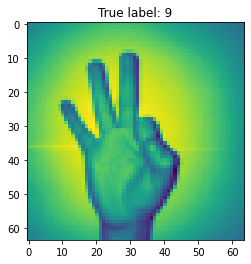

In [237]:
# NOTE 3/3
# Pick and plot the image we'll turn into an adversarial example
idx = 1
img = x_test[idx]
lbl = y_test[idx]

plt.imshow(img[:, :, 0])
plt.title('True label: {}'.format(np.argmax(lbl)))

In [238]:
# NOTE 3/3 nice

model.use_noise.assign(True)
train_batch = 0
n_epochs = 500


# Training loop
for i in range(n_epochs):
    test_accuracy = []
    x = tf.expand_dims(img, axis=0)
    y = [lbl]
    test_accuracy.append(train(model, x, y, i, adversarial=True))

    if i % 50 == 0:
        print('Epoch:\t', i)
        print('Average Training Set Accuracy:\t', np.mean(test_accuracy))
    
# Save model
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write('./checkpoints/model_adversarial')

adv_example = np.array(model.find_x(img))
adv_noise = np.array(model.adv_noise)

Epoch:	 0
Average Training Set Accuracy:	 1.0
Epoch:	 50
Average Training Set Accuracy:	 0.0
Epoch:	 100
Average Training Set Accuracy:	 0.0
Epoch:	 150
Average Training Set Accuracy:	 0.0
Epoch:	 200
Average Training Set Accuracy:	 0.0
Epoch:	 250
Average Training Set Accuracy:	 0.0
Epoch:	 300
Average Training Set Accuracy:	 0.0
Epoch:	 350
Average Training Set Accuracy:	 0.0
Epoch:	 400
Average Training Set Accuracy:	 0.0
Epoch:	 450
Average Training Set Accuracy:	 0.0


## Section 6: Visualize the adversarial example (3/3)
Plot the original example, the adversarial example, and the adversarial noise below.

Text(0.5, 1.0, 'True label: 9')

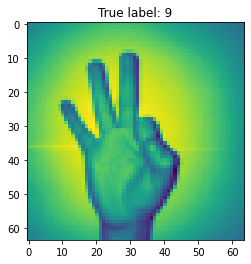

In [239]:
# NOTE 3/3 

plt.imshow(img[:, :, 0])
plt.title('True label: {}'.format(np.argmax(lbl)))

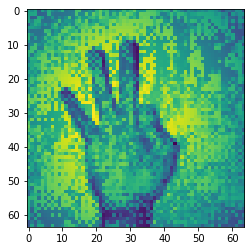

In [240]:
plt.imshow(adv_example[0,:,:,0])

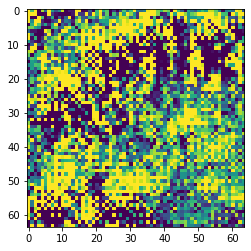

In [241]:
plt.imshow(adv_noise[0,:,:,0])

## Section 7: Demonstrate that the surrogate model fails on the adversarial example
Compute the surrogate model's prediction and probability for the original example and the adversarial example, and compare them. Remember to set the `use_noise` switch to false when computing predictions.

Text(0.5, 1.0, '\n    Image with adversarial noise\n    True: 9\n    Predicted: 4\n    Confidence:1.000')

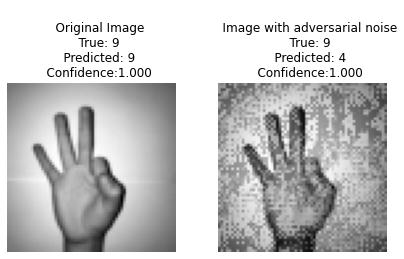

In [242]:
# NOTE 3/3 nice!

_, plots = plt.subplots(ncols=2)
plt.tight_layout()

label_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

model.use_noise.assign(False)
img = np.array([x_test[idx]])
lbl = np.argmax(y_test[idx])

# Plot the model's predictions on the original image
probs = model(img)[0]
pred = label_dict[np.argmax(probs)]
confidence = np.max(probs)
 
plots[0].imshow(img[0, :, :, 0], cmap='gray')
plots[0].axis('off')
plots[0].set_title(
    '''
    Original Image
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(lbl, pred, confidence))

# Plot the model's predictions on the noised image
model.use_noise.assign(True)
img_noised = img + model.adv_noise
probs = model(img_noised)[0]
pred = label_dict[np.argmax(probs)]
confidence = np.max(probs)
 
plots[1].imshow(img_noised[0, :, :, 0], cmap='gray')
plots[1].axis('off')
plots[1].set_title(
    '''
    Image with adversarial noise
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(lbl, pred, confidence))

## 8: Demonstrate that the target model fails on the adversarial example (3/3)
This is the real test -- transferring the learned adversarial example from the surrogate model to the target model.
Compute the target model's prediction and probability for the original example and the adversarial example, and compare them.

Text(0.5, 1.0, '\n    Image with adversarial noise\n    True: 9\n    Predicted: 4\n    Confidence:0.798')

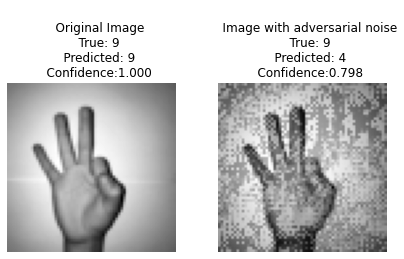

In [243]:
# NOTE 3/3 good job!

_, plots = plt.subplots(ncols=2)
plt.tight_layout()

# Plot the model's predictions on the original image
probs = target_model.predict(img)[0]
pred = label_dict[np.argmax(probs)]
confidence = np.max(probs)
 
plots[0].imshow(img[0, :, :, 0], cmap='gray')
plots[0].axis('off')
plots[0].set_title(
    '''
    Original Image
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(lbl, pred, confidence))

# Plot the model's predictions on the noised image
img_noised = img + adv_noise
probs = target_model.predict(img_noised)[0]
pred = label_dict[np.argmax(probs)]
confidence = np.max(probs)
 
plots[1].imshow(img_noised[0, :, :, 0], cmap='gray')
plots[1].axis('off')
plots[1].set_title(
    '''
    Image with adversarial noise
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(lbl, pred, confidence))

# Congratulations, you've carried out a black-box adversarial attack!
These kinds of adversarial attacks are a serious concern in the real world, since they can be [made to work when printed on paper](https://blog.openai.com/robust-adversarial-inputs/) and [we're still bad at defending against them](https://blog.openai.com/adversarial-example-research/).

Some interesting things to try:
 - Did the surrogate model and the target model misclassify the adversarial example in the same way? (Mine did)
 - How subtle can you make the noise while still tricking the target network?
 - Look at how the adversarial example evolves through training in TensorBoard